<a href="https://colab.research.google.com/github/Lyspal/MCS-IFT6113-Final-Project-DeepSDF/blob/deepsdf-single/Copie_de_deepSDF_single_shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# author: Sylvain Laporte
# program: deepSDF_single_shape.py
# date: 2020-12-08
# object: Implementation of single-shape DeepSDF

# The PyTorch code structure used in this project is adapted from the tutorial "PyTorch: Zero to GANs" by Aakash N.S. for freeCodeCamp.org
# This tutorial is available at https://jovian.ai/aakashns/01-pytorch-basics

# Deep SDF - Single shape

In [ ]:
# # FOR COLAB. Installing packages
# !setup.py install

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
# import trimesh
# import pyrender

## Preprocessing data

We need to sample 500 000 spatial points from a mesh and compute their corresponding SDF values. We sample more aggressively near the surface of the mesh.

### Preprocess the data

In [2]:
# Run from command line tool

### Using already preprocessed data

In [27]:
import json

# Load preprocessed dataset
dataset_file = "cube-samples.json"

points = None
sdfs = None

with open(dataset_file, "r") as f:
    data = json.load(f)
    points = torch.tensor(data['points'])
    sdfs = data['sdfs']

# Convert to a workable list of tuples
dataset = list(zip(points, sdfs))

In [28]:
type(dataset[0][0])

torch.Tensor

### Split dataset in batches

#### Split in trainning dataset and validation dataset

In [29]:
validation_size = 10000
train_size = len(dataset) - validation_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
len(train_dataset), len(validation_dataset)

(240000, 10000)

#### Create batches

In [30]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(validation_dataset, batch_size*2, num_workers=4, pin_memory=True)

## Preparing for running on GPU

In [31]:
# Check if a CUDA GPU is available
torch.cuda.is_available()

True

In [32]:
def get_default_device():
    """Helper function to select the device on which to run the model"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [33]:
# Set and check the default device
device = get_default_device()
device

device(type='cuda')

In [34]:
def to_device(data, device):
    """Helper function to move the data to the chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [35]:
class DeviceDataLoader():
    """Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

### Load dataset to the GPU

In [36]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Training the neural network $f_\theta$

### Loss function

In [141]:
loss_function = nn.L1Loss()

# def clamp(f_theta, delta):
#     max_f_theta = torch.max(f_theta)
#     max_op = max(-delta, max_f_theta)

#     return min(delta, max_op)

# def loss_func(f_theta, s):
#     delta = 0.1     # parameter that controls the distance from the surface
#     return abs(clamp(f_theta, delta) - clamp(s, delta))

### Model

#### Define the model

In [106]:
def accuracy(outputs, sdf_values):
    """For human validation only"""
    pass

In [149]:
class DeepSDF_single(nn.Module):
    """Multi-layer fully-connected feed-forward neural network with 8 layers, each applied with dropout"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # Hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size)
        # Hidden layer 2
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 3
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 4
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 5
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 6
        self.linear6 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 7
        self.linear7 = nn.Linear(hidden_size, hidden_size)
        # Output layer
        self.linear8 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        out = self.linear7(out)
        out = F.relu(out)
        out = self.linear8(out)
        return out
    
    def training_step(self, batch):
        point_samples, sdf_values = batch
        out = self(point_samples)       # generate predictions
        loss = loss_function(out, sdf_values)    # compute loss
        return loss

    def validation_step(self, batch):
        point_samples, sdf_values = batch
        out = self(point_samples)           # generate predictions
        loss = loss_function(out, sdf_values)        # compute loss
        acc = accuracy(out, sdf_values)     # compute accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # combine losses
        return {'val_loss': epoch_loss.item()}

        # batch_accs = [x['val_acc'] for x in outputs]
        # epoch_acc = torch.stack(batch_accs).mean()      # combine accuracies
        # return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss'],))
        # print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#### Create the model

In [150]:
input_size = 3
hidden_size = 512
out_size = 1

model = DeepSDF_single(input_size, hidden_size=hidden_size, out_size=out_size)

In [151]:
# Check the parameters for each layers
for t in model.parameters():
    print(t.shape)

torch.Size([512, 3])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])


#### Load the model on the GPU

In [152]:
to_device(model, device)

DeepSDF_single(
  (linear1): Linear(in_features=3, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=512, bias=True)
  (linear7): Linear(in_features=512, out_features=512, bias=True)
  (linear8): Linear(in_features=512, out_features=1, bias=True)
)

### Train the model

In [153]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [154]:
# Checking the accuracy of the untrained model
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([272])) that is different to the input size (torch.Size([272, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[{'val_loss': 0.06143866396811562}]

In [155]:
epochs = 5
learning_rate = 0.5

print(model.parameters)

# Train the model
history += fit(epochs, learning_rate, model, train_loader, val_loader)

<bound method Module.parameters of DeepSDF_single(
  (linear1): Linear(in_features=3, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=512, bias=True)
  (linear7): Linear(in_features=512, out_features=512, bias=True)
  (linear8): Linear(in_features=512, out_features=1, bias=True)
)>


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [0], val_loss: 1.1121


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([272])) that is different to the input size (torch.Size([272, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [1], val_loss: 0.4830
Epoch [2], val_loss: 0.5879
Epoch [3], val_loss: 0.3970
Epoch [4], val_loss: 0.4194


### Plot the losses and accuracies

In [156]:
# Plot the losses
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Loss vs. No. of epochs')

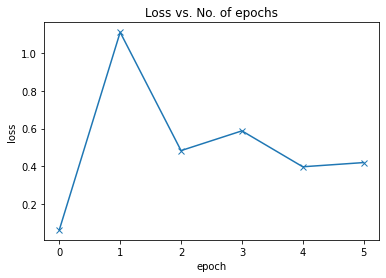

In [158]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

# accuracies = [x['val_acc'] for x in history]
# plt.plot(accuracies, '-x')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.title('Accuracy vs. No. of epochs')

## Render implicit surface

### Get the mesh

### Render the mesh